<a href="https://colab.research.google.com/github/weipengdeng/topic_modelling/blob/main/Journal_analysis_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Import module

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cd /content/drive/MyDrive/Input/Sam/Files #set it as your repo path

/content/drive/.shortcut-targets-by-id/15_rkhW54ASTe3gP5JjEdj3H3DBmq1XFv/Input/Sam/Files


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Patch

In [ ]:
infile = 'Master_Analysis.csv' # Raw dataset
df = pd.read_csv(infile, index_col = 0)

# 1 Percentage distribution

In [ ]:
def format_journal_name(name):
    # Replace '-' with ':'
    name = name.replace('-', ':')

    # Split the name by ':' and handle capitalization
    parts = name.split(':')
    formatted_parts = []

    for part in parts:
        words = part.split()
        formatted_words = [
            word.capitalize() if word.lower() not in ['and', 'of', 'in', 'the'] else word.lower()
            for word in words
        ]
        # Ensure the first word is always capitalized
        formatted_words[0] = formatted_words[0].capitalize()
        formatted_parts.append(' '.join(formatted_words))

    # Join the parts back together with ':'
    return ':'.join(formatted_parts)

# # Example usage
# name = "journal-name of the world"
# formatted_name = format_journal_name(name)
# print(formatted_name)  # Output: "Journal: Name of the World"


In [ ]:
df['fm_journal'] = df['Journal'].apply(format_journal_name)

In [ ]:
# Count the number of articles per journal per year
df_summary = df.groupby(['Year', 'fm_journal']).size().reset_index(name='count')

# Calculate the total number of articles per year
df_total = df_summary.groupby('Year')['count'].sum().reset_index()
df_total = df_total.rename(columns={'count': 'total_count'})

# Merge the total count with the summary
df_summary = df_summary.merge(df_total, on='Year')

# Calculate the percentage of articles from each journal per year
df_summary['percentage'] = (df_summary['count'] / df_summary['total_count']) * 100


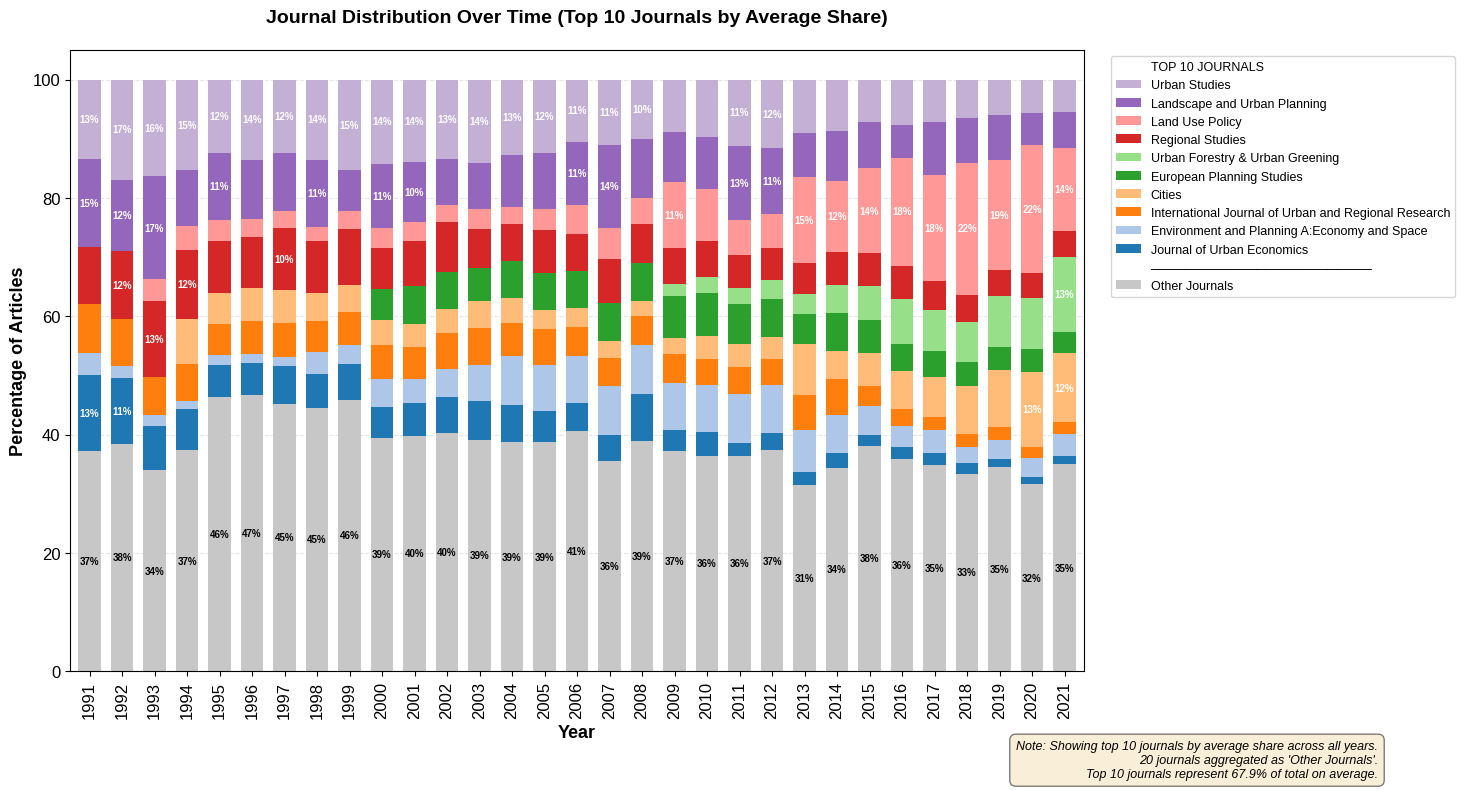


TOP 10 JOURNALS - RANKING AND STATISTICS
 Rank                                              Journal  Mean %  Min %  Max %  Std Dev  Years
    1                                        Urban Studies   11.17   5.42  16.90     3.29     31
    2                         Landscape and Urban Planning    9.63   5.54  17.41     2.67     31
    3                                      Land Use Policy    8.32   2.38  22.31     6.50     29
    4                                     Regional Studies    7.21   4.21  12.79     2.30     31
    5                      Urban Forestry & Urban Greening    5.83   2.00  12.68     3.13     13
    6                            European Planning Studies    5.63   3.58   7.29     1.13     22
    7                                               Cities    5.52   2.52  12.82     2.62     28
    8 International Journal of Urban and Regional Research    4.91   1.80   8.19     1.66     31
    9         Environment and Planning A:Economy and Space    4.91   1.29   8.35     

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Set font settings
plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['font.size'] = 12

# Calculate mean percentage for each journal across all years
journal_means = df_summary.groupby('fm_journal')['percentage'].mean()
top_10_journals = journal_means.nlargest(10).index

# Create modified DataFrame with categories
df_modified = df_summary.copy()
df_modified['journal_category'] = df_modified['fm_journal'].apply(
    lambda x: x if x in top_10_journals else 'Other Journals'
)

# Group and pivot for stacked bar chart
df_grouped = df_modified.groupby(['Year', 'journal_category'])['percentage'].sum().reset_index()
bar_chart_data = df_grouped.pivot(index='Year', columns='journal_category', values='percentage')

# Sort columns by mean percentage (lowest first for bottom stacking), with 'Other' first
journal_means_dict = {col: bar_chart_data[col].mean() for col in bar_chart_data.columns if col != 'Other Journals'}
sorted_journals = sorted(journal_means_dict.keys(), key=journal_means_dict.get)  # ascending order
if 'Other Journals' in bar_chart_data.columns:
    sorted_journals.insert(0, 'Other Journals')  # Put 'Other' at the beginning
bar_chart_data = bar_chart_data[sorted_journals]

# Create color palette using tab20
n_colors = len(bar_chart_data.columns)
# Use tab20 colormap - reserve a muted color for "Other", use vibrant ones for top 10
tab20_colors = plt.cm.tab20.colors
# Use the last gray-ish color from tab20 for "Other Journals", then use the first 10 colors for top journals
colors = [tab20_colors[15]]  # Gray color for "Other Journals"
# Add the first 10 colors from tab20 for top 10 journals
colors.extend(tab20_colors[:n_colors-1])

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked bar chart
bar_chart_data.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.7)

# Customize plot
ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage of Articles', fontsize=13, fontweight='bold')
ax.set_title('Journal Distribution Over Time (Top 10 Journals by Average Share)', fontsize=14, fontweight='bold', pad=20)

# Create custom legend (reverse order to show highest at top)
legend_elements = []
legend_labels = []

# Add header for Top 10
legend_elements.append(Patch(color='none', label=''))
legend_labels.append('TOP 10 JOURNALS')

# Add top 10 journals in descending order of mean percentage
top_10_sorted = sorted([(col, journal_means_dict[col]) for col in journal_means_dict.keys()],
                      key=lambda x: x[1], reverse=True)

for journal, mean_pct in top_10_sorted:
    col_idx = sorted_journals.index(journal)
    legend_elements.append(Patch(facecolor=colors[col_idx], label=''))
    legend_labels.append(journal)

# Add separator
legend_elements.append(Patch(color='none', label=''))
legend_labels.append('─' * 25)

# Add Other Journals
legend_elements.append(Patch(facecolor=colors[0], label=''))
legend_labels.append('Other Journals')

ax.legend(handles=legend_elements, labels=legend_labels,
         bbox_to_anchor=(1.02, 1), loc='upper left',
         fontsize=9, frameon=True, fancybox=True)

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add percentage labels on bars for major segments
for year_idx, year in enumerate(bar_chart_data.index):
    cum_height = 0
    for col in bar_chart_data.columns:
        height = bar_chart_data.loc[year, col]
        if not pd.isna(height) and height > 10:  # Check for NaN and only label segments > 5%
            # Use black text for "Other Journals", white for others
            text_color = 'black' if col == 'Other Journals' else 'white'
            ax.text(year_idx, cum_height + height/2, f'{height:.0f}%',
                   ha='center', va='center', fontsize=7, color=text_color, fontweight='bold')
        if not pd.isna(height):
            cum_height += height

# Calculate statistics for note
n_other_journals = df_summary['fm_journal'].nunique() - 10
top_10_combined = sum([journal_means_dict[j] for j in journal_means_dict.keys()])

# Add informative note
note_text = (f"Note: Showing top 10 journals by average share across all years.\n"
            f"{n_other_journals} journals aggregated as 'Other Journals'.\n"
            f"Top 10 journals represent {top_10_combined:.1f}% of total on average.")
fig.text(0.99, 0.02, note_text, ha='right', fontsize=9,
        style='italic', wrap=True,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.5))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.78, bottom=0.15)

# Save figure
plt.savefig('journal_distribution_top10.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()

# Generate verification tables
print("\n" + "="*80)
print("TOP 10 JOURNALS - RANKING AND STATISTICS")
print("="*80)

# Create detailed stats for top 10
top_10_stats = []
for rank, journal in enumerate(journal_means.nlargest(10).index, 1):
    journal_data = df_summary[df_summary['fm_journal'] == journal]['percentage']
    stats = {
        'Rank': rank,
        'Journal': journal,
        'Mean %': journal_data.mean(),
        'Min %': journal_data.min(),
        'Max %': journal_data.max(),
        'Std Dev': journal_data.std(),
        'Years': len(journal_data)
    }
    top_10_stats.append(stats)

top_10_df = pd.DataFrame(top_10_stats)
for col in ['Mean %', 'Min %', 'Max %', 'Std Dev']:
    top_10_df[col] = top_10_df[col].round(2)

print(top_10_df.to_string(index=False))

# Year-by-year breakdown for top 10
print("\n" + "="*80)
print("YEAR-BY-YEAR BREAKDOWN - TOP 10 JOURNALS")
print("="*80)

top_10_yearly = df_summary[df_summary['fm_journal'].isin(top_10_journals)]
yearly_pivot = top_10_yearly.pivot(index='fm_journal', columns='Year', values='percentage')
yearly_pivot = yearly_pivot.fillna(0).round(1)

# Sort by mean percentage
yearly_pivot['Mean'] = yearly_pivot.mean(axis=1).round(1)
yearly_pivot = yearly_pivot.sort_values('Mean', ascending=False)

print(yearly_pivot.to_string())



# 2 Co-occurrence metrix

In [ ]:
!pip install plotly holoviews bokeh >>output.log

In [ ]:
vdf21 = pd.read_excel('/content/drive/MyDrive/Input/Sam/Files/Result/Relatedness_author_id.xlsx',sheet_name = 'Mx91|21',index_col = 0)

In [ ]:
def remove_last_row(data):
  data = data.iloc[:-1, :]
  data = data.iloc[:, :-1]
  return data

vdf21 = remove_last_row(vdf21)

In [ ]:
vdf21

,6,5,2,3,8,11,4,7,1,12,10,9
6,2719,140,187,74,28,45,193,9,67,74,140,125
5,140,2524,106,33,26,53,140,36,103,69,90,103
2,187,106,3624,188,43,99,110,11,50,145,69,147
3,74,33,188,4031,82,166,188,22,56,303,157,140
8,28,26,43,82,3393,33,51,52,65,127,51,93
11,45,53,99,166,33,2018,73,47,56,129,108,80
4,193,140,110,188,51,73,3688,18,62,206,219,171
7,9,36,11,22,52,47,18,3349,65,47,69,52
1,67,103,50,56,65,56,62,65,2712,91,73,87
12,74,69,145,303,127,129,206,47,91,3965,146,161


In [ ]:
file_path = '/content/drive/MyDrive/Input/Sam/Files/Result/Relatedness_author_id.xlsx'
sheet_name = 'Tp91|21'
names = pd.read_excel(file_path, sheet_name=sheet_name, usecols=['ID', 'Name'])

In [ ]:
names

,ID,Name
0,3,T3-Socio-political geography
1,12,T12-Planning policy and community governance
2,4,T4-Housing and property market
3,2,T2-Regional economics
4,8,T8-Environmental management
5,7,T7-Landscape and forestry
6,10,T10-Neighbourhood planning
7,6,T6-Spatial effect
8,1,T1-Spatial analysis and modelling
9,5,T5-Transportation


In [ ]:
!pip install plotapi

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
vdf21

,6,5,2,3,8,11,4,7,1,12,10,9
6,2719,140,187,74,28,45,193,9,67,74,140,125
5,140,2524,106,33,26,53,140,36,103,69,90,103
2,187,106,3624,188,43,99,110,11,50,145,69,147
3,74,33,188,4031,82,166,188,22,56,303,157,140
8,28,26,43,82,3393,33,51,52,65,127,51,93
11,45,53,99,166,33,2018,73,47,56,129,108,80
4,193,140,110,188,51,73,3688,18,62,206,219,171
7,9,36,11,22,52,47,18,3349,65,47,69,52
1,67,103,50,56,65,56,62,65,2712,91,73,87
12,74,69,145,303,127,129,206,47,91,3965,146,161


In [ ]:
import pandas as pd

def remove_last_row(data):
    data = data.iloc[:-1, :]  #
    data = data.iloc[:, :-1]  #
    return data

def normalize_mt(value):
    #
    value = value.astype(float)

    #
    indices = value.columns.tolist()  #
    row_indices = value.index.tolist()  #

    #
    od_pairs = []

    for i in range(len(value)):
        for j in range(len(value)):
            if i != j:  #
                origin = row_indices[i]
                destination = indices[j]
                normalized_value = (value.iloc[i, j] / value.iloc[i, i])*100 #
                od_pairs.append([origin, destination, normalized_value])
            elif i == j:
                origin = row_indices[i]
                destination = indices[j]
                normalized_value = 0
                od_pairs.append([origin, destination, normalized_value])

    #
    od_df = pd.DataFrame(od_pairs, columns=['Origin', 'Destination', 'Normalized Value'])
    #
    od_df['Origin'] = od_df['Origin'].astype(int)
    od_df['Destination'] = od_df['Destination'].astype(int)

    od_df = od_df.sort_values(by=['Origin', 'Destination'])


    od_df['Cross-Topic Authorship (%) by Origin Topic'] = 'T' + od_df['Origin'].astype(str)
    od_df['Cross-Topic Authorship (%) by Destination Topic'] = 'T' + od_df['Destination'].astype(str)
    od_df = pd.merge(od_df, names, left_on='Origin', right_on='ID', how='left')
    od_df = od_df.drop(columns=['ID'])
    od_df = od_df.rename(columns={'Name': 'Origin Name'})
    od_df = pd.merge(od_df, names, left_on='Destination', right_on='ID', how='left')
    od_df = od_df.drop(columns=['ID'])
    od_df = od_df.rename(columns={'Name': 'Destination Name'})
    max_value = od_df['Normalized Value'].max()
    return od_df,max_value

#normalize_mt(vdf21)

In [ ]:
filepath = '/content/drive/MyDrive/Input/Sam/Files/Result/Relatedness_author_id.xlsx'
output_filepath = 'Result/nmlod_bidir_Relatedness_author_id.xlsx'

with pd.ExcelWriter(output_filepath) as writer:
    for sheet in pd.ExcelFile(filepath).sheet_names:
        if 'Mx' in sheet:

            df = pd.read_excel(filepath, sheet_name=sheet,index_col = 0, header = 0)

            #
            df = df.apply(pd.to_numeric, errors='coerce')
            df = remove_last_row(df)

            try:
                od_df,max_value = normalize_mt(df)
                print(f"Max value in the {sheet}: {max_value}")
                new_sheetname = sheet.replace('Mx', 'OD')
                od_df.to_excel(writer, sheet_name=new_sheetname, index=False)
            except TypeError as e:
                print(f"Skipping sheet {sheet} due to TypeError: {e}")

print(f"Processed data saved to {output_filepath}")

Max value in the Mx91|21: 8.225966303270566
Max value in the Mx91-00: 8.677685950413224
Max value in the Mx01-05: 7.876712328767123
Max value in the Mx06-10: 5.714285714285714
Max value in the Mx11-15: 6.329113924050633
Max value in the Mx16-18: 3.966597077244259
Max value in the Mx19-21: 4.580152671755725
Processed data saved to Result/nmlod_bidir_Relatedness_author_id.xlsx


# 3 Table convert

# 4 Standarized table of the heat map matrix

In [ ]:
import tqdm

In [ ]:
df.columns

Index(['Document', 'Dominant Topic', 'Labels', 'Topic_Concat', 'Topic',
       'Contribution %', 'Topic Desc', 'Title', 'Author', 'Author_Count',
       'Abstract', 'Author_Address', 'AuthorKeyword', 'KeywordsPlus',
       'CitedReference', 'Year', 'Interval', 'ResearchArea', 'Journal',
       'CitedCount', 'AuthorAffiliation', 'CorrespondingAuthorAffiliation',
       'Abstract_Title_Keywords', 'Page_Number'],
      dtype='object')

In [ ]:
# test = pd.read_csv('Result/author_id/Mx91|21.csv',index_col = 0)

In [ ]:
# test #The data structure of the matrix showing the correlation between topic

,6,5,2,3,8,11,4,7,1,12,10,9,Total
Unnamed: 0,,,,,,,,,,,,,
6,2719,140,187,74,28,45,193,9,67,74,140,125,2719
5,140,2524,106,33,26,53,140,36,103,69,90,103,2524
2,187,106,3624,188,43,99,110,11,50,145,69,147,3624
3,74,33,188,4031,82,166,188,22,56,303,157,140,4031
8,28,26,43,82,3393,33,51,52,65,127,51,93,3393
11,45,53,99,166,33,2018,73,47,56,129,108,80,2018
4,193,140,110,188,51,73,3688,18,62,206,219,171,3688
7,9,36,11,22,52,47,18,3349,65,47,69,52,3349
1,67,103,50,56,65,56,62,65,2712,91,73,87,2712


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import glob
import os
matplotlib.rcParams['pdf.fonttype'] = 42  # Ensure fonts are editable

def process_heatmap(df, filename):
    """Process a single data file and generate heatmap"""
    # Remove Total row and column
    df_clean = df.drop(index="Total", errors="ignore").drop(columns=["Total"], errors="ignore")

    # Sort rows and columns by numeric value
    def sort_key(x):
        try:
            return int(str(x))
        except:
            return float('inf')

    # Sort index and columns numerically
    sorted_index = sorted(df_clean.index, key=sort_key)
    sorted_columns = sorted(df_clean.columns, key=sort_key)
    df_clean = df_clean.loc[sorted_index, sorted_columns]

    # Find maximum off-diagonal value
    mask_offdiag = ~np.eye(df_clean.shape[0], dtype=bool)
    max_offdiag = df_clean.where(mask_offdiag).max().max()

    # Normalize
    df_norm = df_clean / max_offdiag
    np.fill_diagonal(df_norm.values, np.nan)  # Set diagonal to NaN

    # Create labels with T prefix
    topic_labels = [f'T{x}' for x in df_norm.index]

    # Create figure, adjust size for clear text display
    plt.figure(figsize=(12, 10))

    # Use red-blue colormap
    sns.heatmap(df_norm,
                cmap="RdYlBu_r",  # Red-Yellow-Blue reversed, from red to blue
                annot=False,
                vmin=0,
                vmax=1,
                cbar_kws={'label': 'Normalized co-occurrence', 'shrink': 0.8},
                square=True,  # Make heatmap cells square
                linewidths=0.8,  # Add gridlines
                xticklabels=topic_labels,  # Use T prefix labels
                yticklabels=topic_labels)  # Use T prefix labels

    # Extract identifier from filename for title
    file_id = os.path.basename(filename).replace('.csv', '')
    plt.title(f"Normalized cross-topic co-occurrence ({file_id})",
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Topic", fontsize=24, fontweight='bold')
    plt.ylabel("Topic", fontsize=24, fontweight='bold')

    # Set font size for axis labels
    plt.xticks(fontsize=20, rotation=0)
    plt.yticks(fontsize=20, rotation=0)

    # Set colorbar font size
    cbar = plt.gca().collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Normalized co-occurrence', fontsize=12, fontweight='bold')

    plt.tight_layout()

    return plt.gcf()

# Set file path
folder_path = "Result/author_id/"
output_pdf = "Result/author_id/all_heatmaps_Mx.pdf"

# Find all CSV files starting with Mx
csv_files = glob.glob(os.path.join(folder_path, "Mx*.csv"))
csv_files.sort()  # Sort by filename

print(f"Found {len(csv_files)} CSV files starting with Mx:")
for file in csv_files:
    print(f"  - {os.path.basename(file)}")

# Batch process and save to single PDF
with PdfPages(output_pdf) as pdf:
    for csv_file in csv_files:
        try:
            print(f"Processing: {os.path.basename(csv_file)}")

            # Read CSV file
            df = pd.read_csv(csv_file, index_col=0)

            # Generate heatmap
            fig = process_heatmap(df, csv_file)

            # Save to PDF
            pdf.savefig(fig, bbox_inches='tight', dpi=300)

            # Close current figure to free memory
            plt.close(fig)

        except Exception as e:
            print(f"Error processing file {csv_file}: {str(e)}")
            continue

print(f"\nAll heatmaps saved to: {output_pdf}")

# Optional: Save individual PNG files for each file
save_individual_png = False  # Set to True if individual PNG files are needed

if save_individual_png:
    print("\nSaving individual PNG files...")
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file, index_col=0)
            fig = process_heatmap(df, csv_file)

            # Generate PNG filename
            png_filename = os.path.basename(csv_file).replace('.csv', '_heatmap.png')
            plt.savefig(png_filename, format='png', dpi=300, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
            print(f"  Saved: {png_filename}")

            plt.close(fig)

        except Exception as e:
            print(f"Error saving PNG file {csv_file}: {str(e)}")
            continue

print("\nBatch processing complete!")

Found 7 CSV files starting with Mx:
  - Mx01-05.csv
  - Mx06-10.csv
  - Mx11-15.csv
  - Mx16-18.csv
  - Mx19-21.csv
  - Mx91-00.csv
  - Mx91|21.csv
Processing: Mx01-05.csv
Processing: Mx06-10.csv
Processing: Mx11-15.csv
Processing: Mx16-18.csv
Processing: Mx19-21.csv
Processing: Mx91-00.csv
Processing: Mx91|21.csv

All heatmaps saved to: Result/author_id/all_heatmaps_Mx.pdf

Batch processing complete!


# Research topic Rank

In [ ]:
infile = 'Master_Analysis.csv' # Raw dataset
df = pd.read_csv(infile, index_col = 0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

In [ ]:
import os

font_url = 'https://github.com/jonasschneider/presi/blob/master/fonts/Gill%20Sans%20MT.ttf?raw=true'
font_filename = 'GillSansMT.ttf'

# Download the font file
!wget -O {font_filename} {font_url}

--2025-12-10 05:47:18--  https://github.com/jonasschneider/presi/blob/master/fonts/Gill%20Sans%20MT.ttf?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jonasschneider/presi/raw/refs/heads/master/fonts/Gill%20Sans%20MT.ttf [following]
--2025-12-10 05:47:19--  https://github.com/jonasschneider/presi/raw/refs/heads/master/fonts/Gill%20Sans%20MT.ttf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jonasschneider/presi/refs/heads/master/fonts/Gill%20Sans%20MT.ttf [following]
--2025-12-10 05:47:19--  https://raw.githubusercontent.com/jonasschneider/presi/refs/heads/master/fonts/Gill%20Sans%20MT.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubus

In [ ]:
import matplotlib.font_manager as fm # Add this import statement

# Step 1: Font file is already downloaded in the previous step
font_filename = 'GillSansMT.ttf'

# Step 2: Add the font to Matplotlib
font_path = font_filename
fontprop = fm.FontProperties(fname=font_path)

# Step 3: Set the font globally
plt.rcParams['font.family'] = fontprop.get_name()

In [ ]:
import matplotlib.font_manager as fm

# Get a list of all font families accessible to Matplotlib
font_list = sorted([f.name for f in fm.fontManager.ttflist])

print("Available Font Families:")
for font_name in font_list:
    print(f"- {font_name}")

Size Data:
Interval                                      1991-2000  2001-2005  2006-2010  \
Topic                                                                           
T1-Spatial analysis and modelling                   439        202        416   
T10-Neighbourhood planning                          364        340        482   
T11-Public space and urban design                   286        262        347   
T12-Planning policy and community governance        752        578        610   
T2-Regional economics                               698        655        834   
T3-Socio-political geography                        657        570        680   
T4-Housing and property market                     1002        584        626   
T5-Transportation                                   548        335        432   
T6-Spatial effect                                   561        412        485   
T7-Landscape and forestry                           394        236        445   
T8-Environmental 

/tmp/ipython-input-884621839.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(sorted_topics))  # qualitative colormap


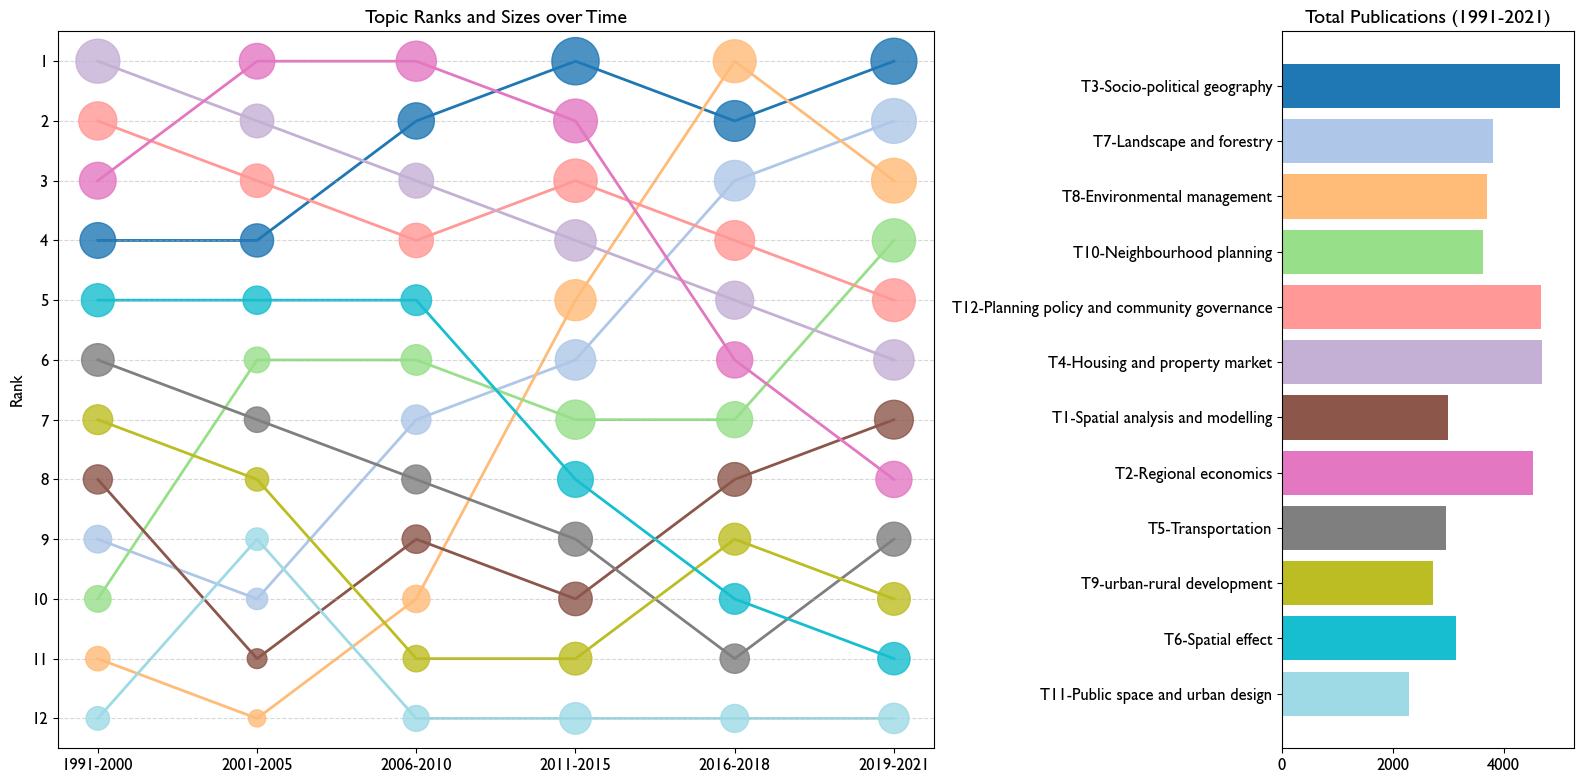


TOTAL PUBLICATIONS AND RANKS BY TOPIC
                                       Topic  Total Publications  Rank
                T3-Socio-political geography                5017     1
              T4-Housing and property market                4685     2
T12-Planning policy and community governance                4671     3
                       T2-Regional economics                4529     4
                   T7-Landscape and forestry                3811     5
                 T8-Environmental management                3701     6
                  T10-Neighbourhood planning                3617     7
                           T6-Spatial effect                3144     8
           T1-Spatial analysis and modelling                3002     9
                           T5-Transportation                2953    10
                  T9-urban-rural development                2730    11
           T11-Public space and urban design                2287    12


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
# Set the font globally to 'Gill Sans MT'
plt.rcParams['font.family'] = 'Gill Sans MT'

# Define the periods
periods = ["1991-2000", "2001-2005", "2006-2010", "2011-2015", "2016-2018", "2019-2021"]

# Get topic counts by period
topic_counts = df.groupby(['Interval', 'Topic']).size().reset_index(name='count')

# Pivot to get topics as rows and periods as columns
size_data_df = topic_counts.pivot(index='Topic', columns='Interval', values='count').fillna(0).astype(int)

# Reorder columns to match the periods list
size_df = size_data_df[periods]

# Calculate ranks for each period (1 = highest count, 12 = lowest count)
rank_df = size_df.rank(ascending=False, method='min', axis=0).astype(int)

# Convert to dictionaries if needed
size_data = size_df.to_dict('index')
rank_data = rank_df.to_dict('index')

# Display the results
print("Size Data:")
print(size_df)
print("\nRank Data:")
print(rank_df)

# Final period ranking order - get the last column
final_rank = rank_df[periods[-1]].sort_values().to_dict()
sorted_topics = list(final_rank.keys())

# -----------------------
# Assign Unique Colors
# -----------------------
cmap = cm.get_cmap("tab20", len(sorted_topics))  # qualitative colormap
topic_colors = {topic: cmap(i) for i, topic in enumerate(sorted_topics)}

# -----------------------
# Plot
# -----------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [3, 1]})

# Left side: rank trajectories with bubble size
for topic in sorted_topics:
    ranks = rank_df.loc[topic].values
    sizes = size_df.loc[topic].values
    ax1.plot(periods, ranks, lw=2, color=topic_colors[topic], label=topic, zorder=1)
    ax1.scatter(periods, ranks, s=np.array(sizes)/1, alpha=0.8, color=topic_colors[topic], zorder=2)

ax1.set_ylim(12.5, 0.5)
ax1.set_yticks(range(1, 13, 1))   # y-axis from 1 to 12
ax1.set_ylabel("Rank")
ax1.set_title("Topic Ranks and Sizes over Time")
ax1.grid(True, axis='y', linestyle="--", alpha=0.5)

# Right side: bar chart of total size
total_size = size_df.sum(axis=1).reindex(sorted_topics)
colors = [topic_colors[t] for t in total_size.index]
ax2.barh(total_size.index, total_size.values, color=colors)
ax2.set_title("Total Publications (1991-2021)")
ax2.invert_yaxis()

plt.tight_layout()

# -----------------------
# Save as editable PDF
# -----------------------
plt.savefig("topic_trends.pdf", format="pdf")
plt.show()

# -----------------------
# Calculate Total Publication Ranks
# -----------------------
print("\n" + "="*80)
print("TOTAL PUBLICATIONS AND RANKS BY TOPIC")
print("="*80)

# Calculate total publications for each topic
total_publications = size_df.sum(axis=1)

# Calculate rank (1 = highest total, 12 = lowest total)
total_rank = total_publications.rank(ascending=False, method='min').astype(int)

# Create summary dataframe
summary_df = pd.DataFrame({
    'Topic': total_publications.index,
    'Total Publications': total_publications.values,
    'Rank': total_rank.values
})

# Sort by rank
summary_df = summary_df.sort_values('Rank')

print(summary_df.to_string(index=False))
print("="*80)